In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.units import Hartree,kcal,mol
import re

In [2]:
kcalmol = kcal/mol
H_to_kcalmol = Hartree/kcalmol

In [3]:
def timestamp_split(direc):
    log = [i for i in os.listdir(direc) if '.log' in i][0]
    ts = '.'.join(log.split('.')[:2])
    return ts    

def split(el):
    import re
    #Splits a string on capital letter sequences
    res_list = [s for s in re.split("([A-Z][^A-Z]*)", el) if s]
    ret_list = []
    def expand(subel):
        match = re.match(r"([a-z]+)([0-9]+)", subel, re.I)
        if match:
            el, num = match.groups()
            num = int(num)
            subl = num*[el]
            return subl
        else:
            return [subel]
    for res in res_list:
        ret_list += expand(res)
    return ret_list



def plot_ae_output(aedf, figp, savename = None, percent=True, title=None,
                  xlim = (0, None), ylim = (None,None), ylabfont = ['% Change', 14],
                  xlabfont = ['Epoch', 14], fileend='.pdf', log=False, escale=1, skipat=True, **kwargs):
    aeg = aedf.groupby(['sym','Epoch']).mean()
    df = aeg

    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111)
    
    if percent:
        ptitle = title if title else 'Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]'
        savesuff = '_per'
    else:
        #ptitle = title if title else 'Start: Pre-trained SCAN\nChange in Atomization Energy Loss\n y = (y-y[0])'
        ptitle = title if title else 'Start: Pre-trained SCAN\nAtomization Energy Loss'
        savesuff = '_dev'

    syms = np.unique(aedf['sym'].values)
    for s in syms:
        print(s)
        if len(split(s.strip())) == 1:
            print("{} -- Single atom in AE plot -- skipping.".format(s))
            continue
        y = escale*df.loc[s]['ae'].values
        if percent:
            y = (y - y[0])/y[0]
        else:
            #y = (y - y[0])
            y = y
        ax.plot(y, label=s)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(ncol=2)
    ax.grid()

    ax.set_title(ptitle, fontsize=16)
    ax.set_ylabel(ylabfont[0], fontsize=ylabfont[1])
    ax.set_xlabel(xlabfont[0], fontsize=xlabfont[1])
    
    if log:
        ax.set_yscale('symlog')
    
    plt.tight_layout()
    if savename:
        plt.savefig(os.path.join(figp, savename+savesuff+fileend), dpi=800)
    return (f, ax)

def plot_te_output(tedf, figp, savename = None, percent=True, title=None,
                  xlim = (0, None), ylim = (None,None), ylabfont = ['% Change', 14],
                  xlabfont = ['Epoch', 14], fileend='.pdf', log=False, escale=1, **kwargs):
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111)

    tel = escale*tedf['E'].values
    ter = tedf['rho'].values
    tea = escale*tedf['ae'].values
    tet = tedf['total'].values
    
    if percent:
        tel = (tel - tel[0])/tel[0]
        ter = (ter - ter[0])/ter[0]
        tea = (tea - tea[0])/tea[0]
        tet = (tet - tet[0])/tet[0]
        ptitle = title if title else 'Start: Pre-trained SCAN\nPercent Change in Aggregate Losses\n y = (y-y[0])/y[0]'
        savesuff = '_per'

    else:
#         tel = (tel - tel[0])
#         ter = (ter - ter[0])
#         tea = (tea - tea[0])
#         tet = (tet - tet[0])
        tel = tel
        ter = ter
        tea = tea
        tet = tet
        #ptitle = title if title else 'Start: Pre-trained SCAN\nChange in Aggregate Losses\n y = (y-y[0])'
        ptitle = title if title else 'Start: Pre-trained SCAN\nAggregate Losses'
        savesuff = '_dev'
        
    ax.plot(tel, label='E')
    ax.plot(ter, label='rho')
    ax.plot(tea, label='ae')
    ax.plot(tet, label='Total')


    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(ncol=2)
    ax.grid()

    ax.set_title(ptitle, fontsize=16)
    ax.set_ylabel(ylabfont[0], fontsize=ylabfont[1])
    ax.set_xlabel(xlabfont[0], fontsize=xlabfont[1])
    
    if log:
        ax.set_yscale('symlog')
    
    plt.tight_layout()
    if savename:
        plt.savefig(os.path.join(figp, savename+savesuff+fileend), dpi=800)
    return (f, ax)

        
def plot_eval_output(eedf, figp, savename = None, percent=True, title=None,
                  xlim = (0, None), ylim = (None,None), ylabfont1 = ['% Change\nEnergy Loss Value', 14],
                  xlabfont1 = ['Epoch', 14], ylabfont2 = ['% Change\nRho Loss Value', 14],
                     xlabfont2 = ['Epoch', 14], fileend='.pdf', log=False, escale=1, **kwargs):
    def get_col_key(form, odf, key):
        ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
        if key == ks[0]:
            return 'k1l'
        elif key == ks[1]:
            return 'k2l'
        else:
            return None
        
    eg = eedf.groupby(['form', 'Epoch']).mean()
    syms = np.unique(eedf['form'].values)
    f = plt.figure(figsize=(8, 8))
    eax = f.add_subplot(211)
    rax = f.add_subplot(212)
    ks = ['E','rho']
    for s in syms:
        ek = get_col_key(s, eedf, key='E')
        rk = get_col_key(s, eedf, key='rho')
        if ek:
            if percent:
                ey = eg.loc[s][ek].values
                ey = (ey-ey[0])/ey[0]
                eax.plot(ey, label=s)
                savesuff = '_per'
                ptitle = title if title else 'Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]'
            else:
                ey = eg.loc[s][ek].values
                #ey = (ey-ey[0])*escale
                ey = (ey)*escale
                eax.plot(ey, label=s)
                savesuff = '_dev'
                #ptitle = title if title else 'Start: Pre-trained SCAN\nChange in E/Rho Losses\n y = (y-y[0])'
                ptitle = title if title else 'Start: Pre-trained SCAN\nE/Rho Losses'
            
        if rk:
            if percent:
                ry = eg.loc[s][rk].values
                ry = (ry-ry[0])/ry[0]
                rax.plot(ry, label=s)
                savesuff = '_per'
                ptitle = title if title else 'Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]'
            else:
                ry = eg.loc[s][rk].values
                #ry = (ry-ry[0])
                ry = (ry)
                rax.plot(ry, label=s)
                savesuff = '_dev'
                #ptitle = title if title else 'Start: Pre-trained SCAN\nChange in E/Rho Losses\n y = (y-y[0])'
                ptitle = title if title else 'Start: Pre-trained SCAN\nE/Rho Losses'
            
    eax.legend()
    rax.legend()

    eax.grid()
    rax.grid()

    eax.set_ylabel(ylabfont1[0], fontsize = ylabfont1[1])
    rax.set_ylabel(ylabfont2[0], fontsize = ylabfont2[1])

    rax.set_xlabel(xlabfont2[0], fontsize = xlabfont2[1])

    eax.set_title(ptitle, fontsize=16)
    
    if log:
        eax.set_yscale('symlog')
        rax.set_yscale('symlog')

    plt.tight_layout()
    if savename:
        plt.savefig(os.path.join(figp, savename+savesuff+fileend), dpi=800)
    return (f, eax, rax)

def plot_train_outputs(direc, aesuff = '_aeloss.dat', tesuff = '_totallosses.dat', eesuff = '_evalloss.dat',
                      figp = '/home/awills/Documents/Research/figs/ml', **kwargs):
    
    ts = timestamp_split(direc)
    aep = os.path.join(direc, ts+aesuff)
    tep = os.path.join(direc, ts+tesuff)
    eep = os.path.join(direc, ts+eesuff)

    ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
    te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
    ee = pd.read_csv(eep, delimiter='\t', skiprows=0, index_col=False, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])
    
    f1, ax1 = plot_ae_output(aedf=ae, figp=figp, savename = kwargs.get('aesave', None), **kwargs)
    
    f2, ax2 = plot_te_output(tedf=te, figp=figp, savename = kwargs.get('tesave', None), **kwargs)
    
    f3, eax3, rax3 = plot_eval_output(eedf=ee, figp=figp, savename = kwargs.get('eesave', None), **kwargs)
    
    return [(f1, ax1), (f2, ax2), (f3, eax3, rax3)]

 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 N 
 N  -- Single atom in AE plot -- skipping.
 N2 
 F 
 F  -- Single atom in AE plot -- skipping.
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 LiF 
 N 
 N  -- Single atom in AE plot -- skipping.
 N2 
 C 
 C  -- Single atom in AE plot -- skipping.
 CNH 
 F 
 F  -- Single atom in AE plot -- skipping.
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 LiF 
 N 
 N  -- Single atom in AE plot -- skipping.
 N2 
 C 
 C  -- Single atom in AE plot -- skipping.
 CNH 
 CO2 
 F 
 F  -- Single atom in AE plot -- skipping.
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 LiF 
 N 
 N  -- Single atom in AE plot -- skipping.
 N2 
 O 
 O  -- Single atom in AE plot -- skipping.
 C 
 C  -- Single atom in AE plot -- skipping.
 CNH 
 CO2 
 Cl 
 Cl

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 C 
 C  -- Single atom in AE plot -- skipping.
 Cl 
 Cl  -- Single atom in AE plot -- skipping.
 Cl2 
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 Cl 
 Cl  -- Single atom in AE plot -- skipping.
 Cl2 
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 C 
 C  -- Single atom in AE plot -- skipping.
 CNH 
 CO2 
 Cl 
 Cl  -- Single atom in AE plot -- skipping.
 Cl2 
 F 
 F  -- Single atom in AE plot -- skipping.
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 LiF 
 N 
 N  -- Single atom in AE plot -- skipping.
 N2 
 O 
 O  -- Single atom in AE plot -- skipping.
 C 
 C  -- Single atom in AE plot -- skipping.
 Cl 
 Cl  -- Single atom in AE plot -- skipping.
 Cl2 
 H 
 H  -- Single atom in AE plot -- skipping.
 H2 
 Li 
 Li  -- Single atom in AE plot -- skipping.
 Cl 
 Cl  -- Single atom in AE plot -- skipping.
 Cl2 
 H 
 H  -- Singl

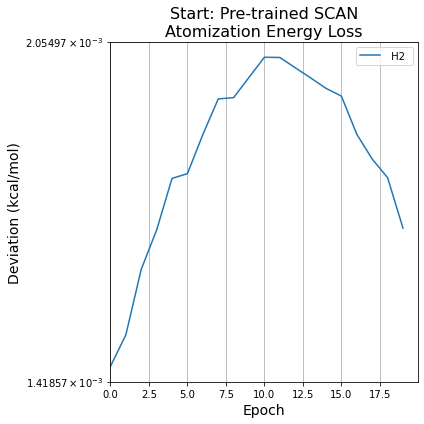

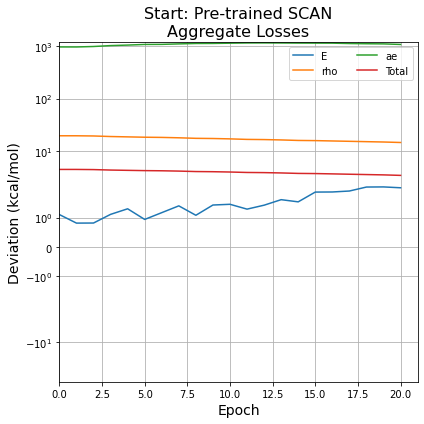

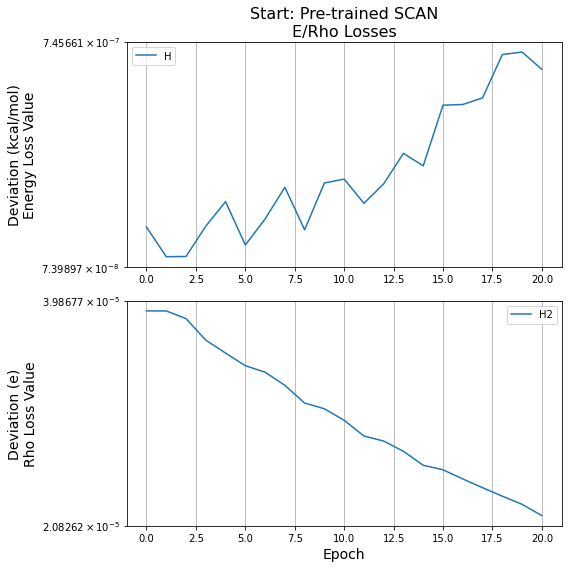

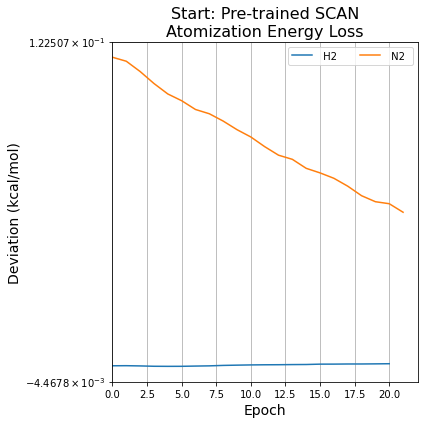

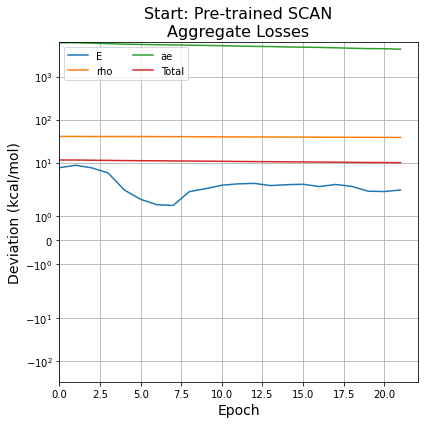

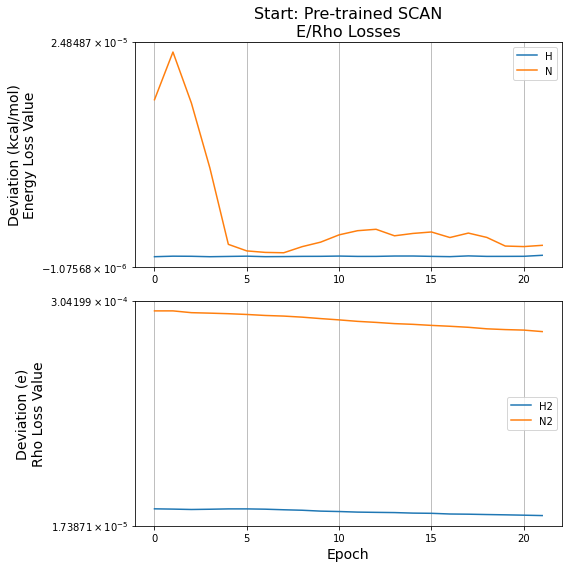

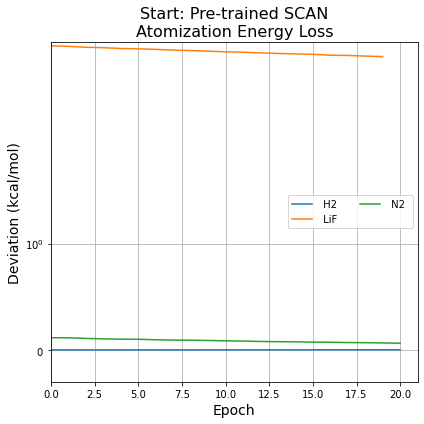

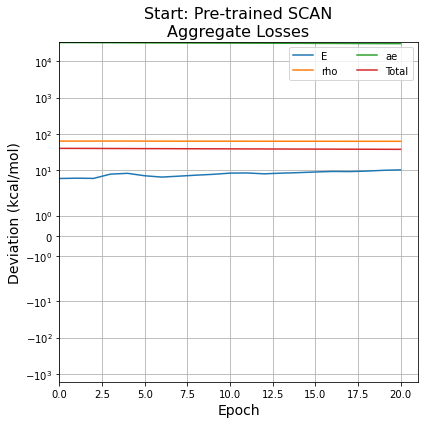

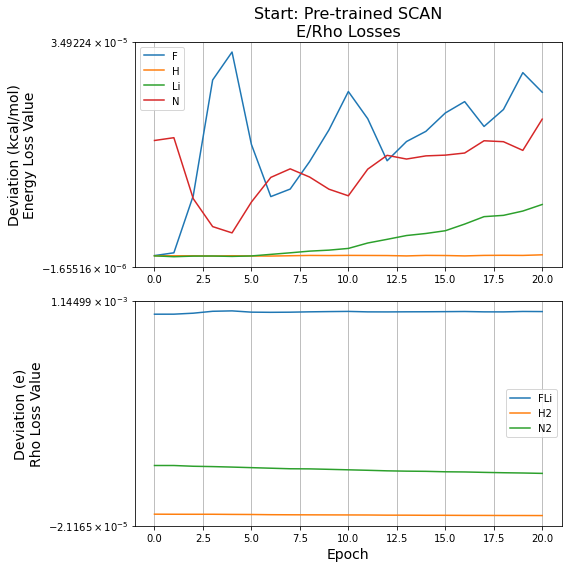

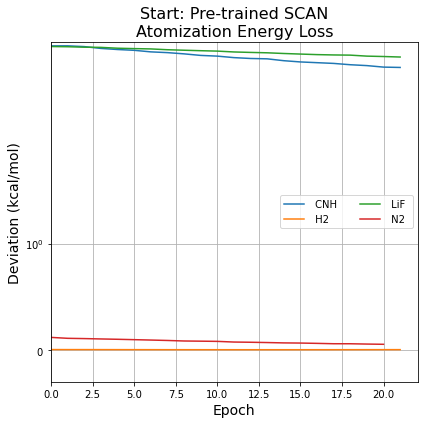

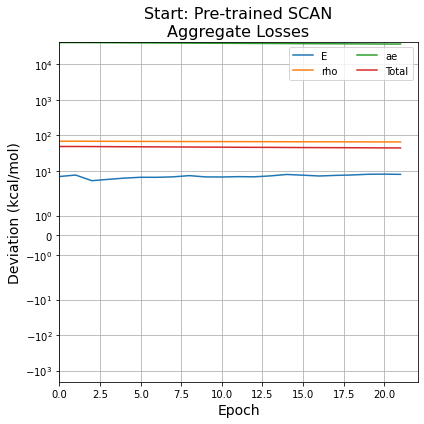

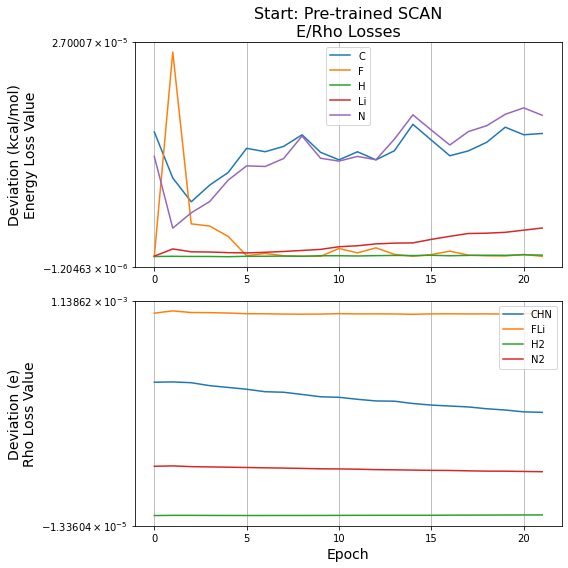

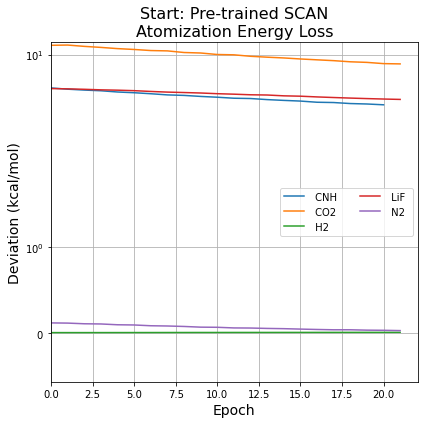

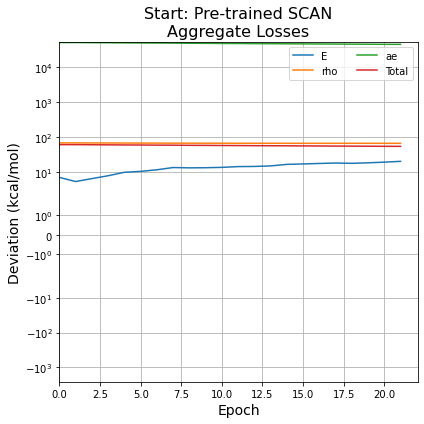

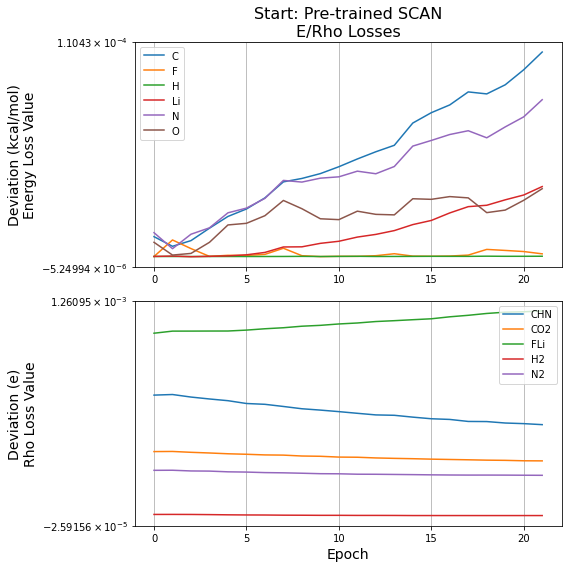

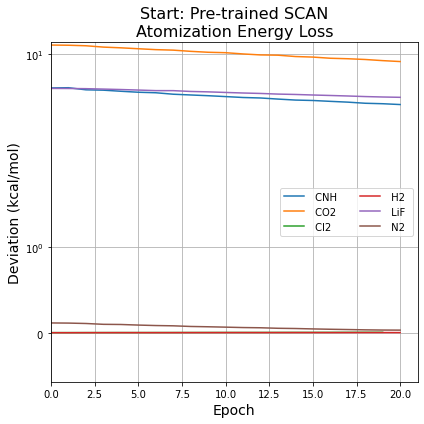

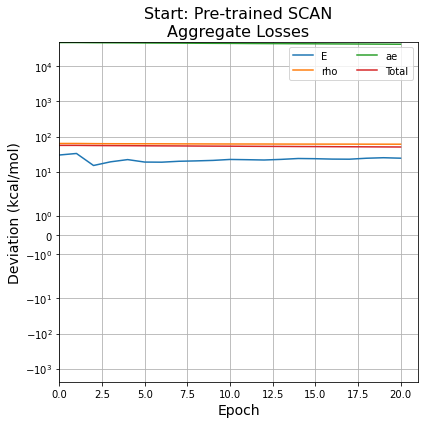

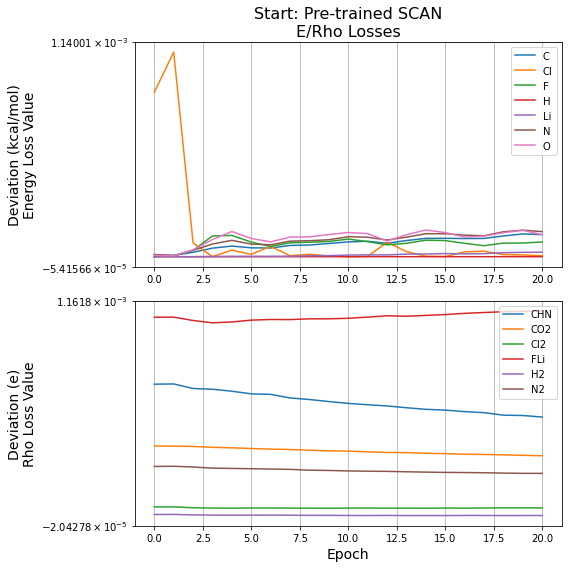

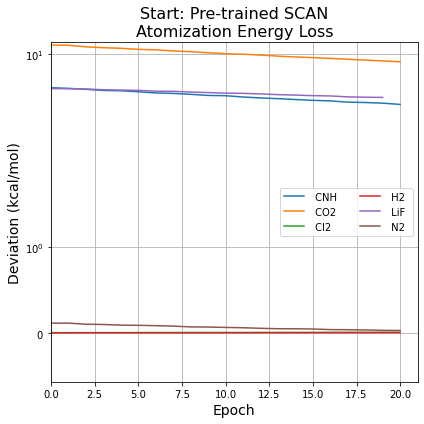

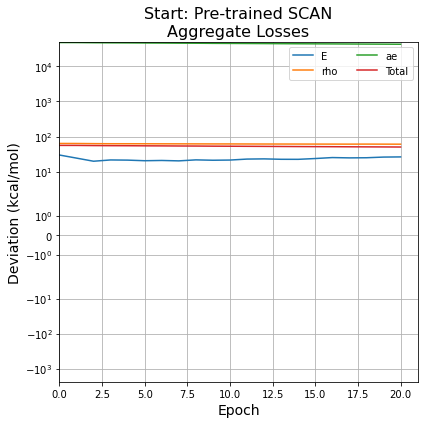

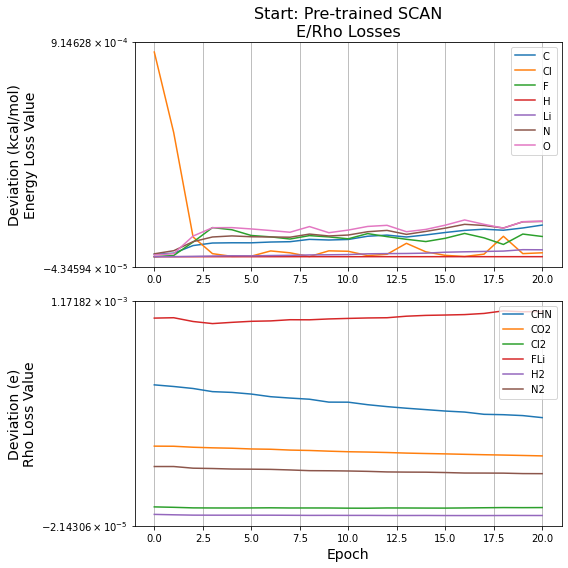

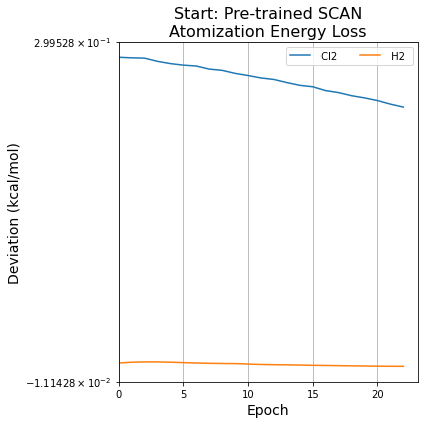

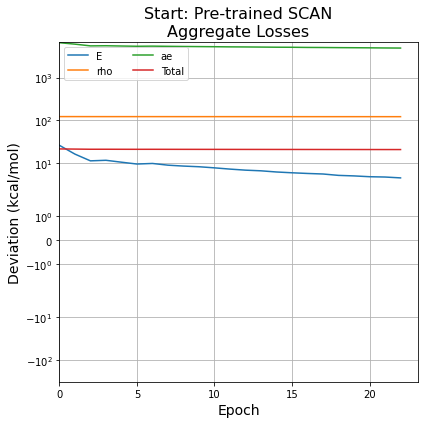

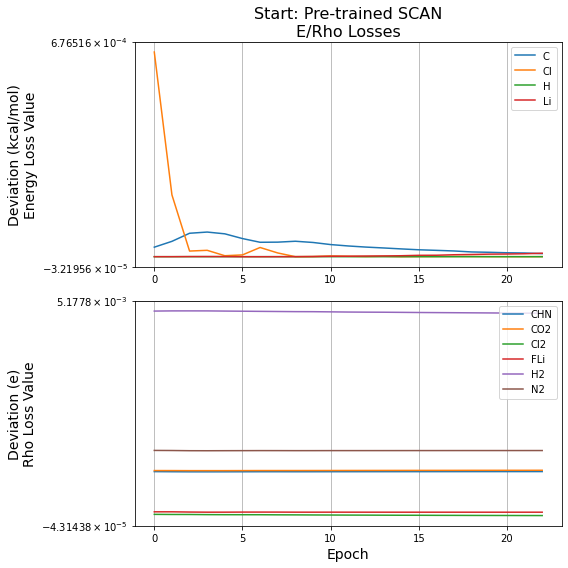

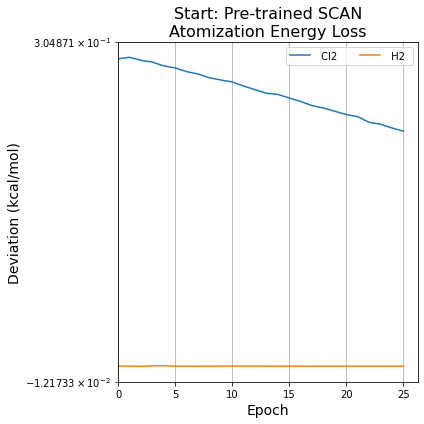

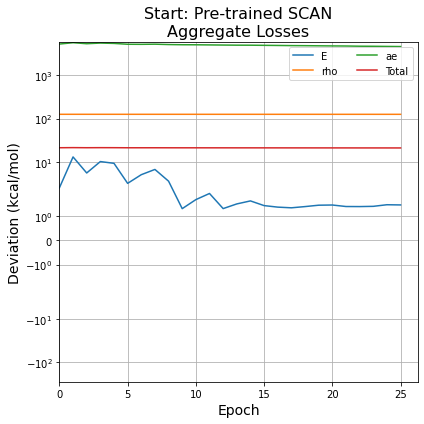

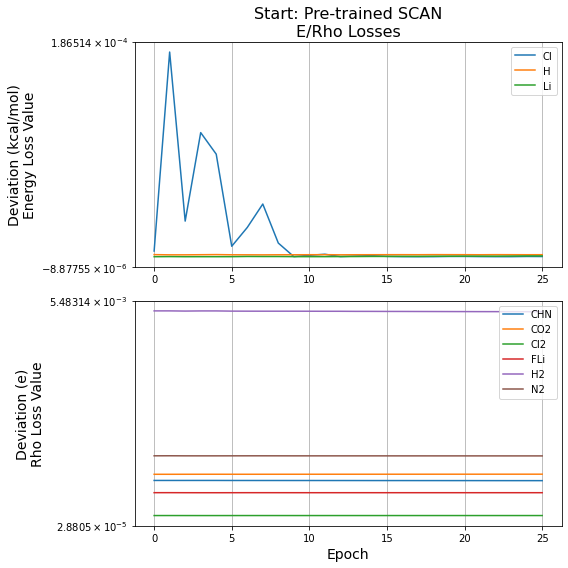

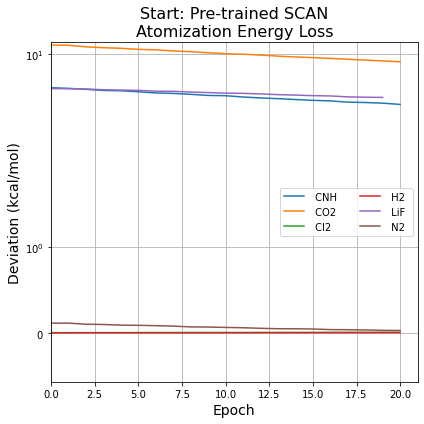

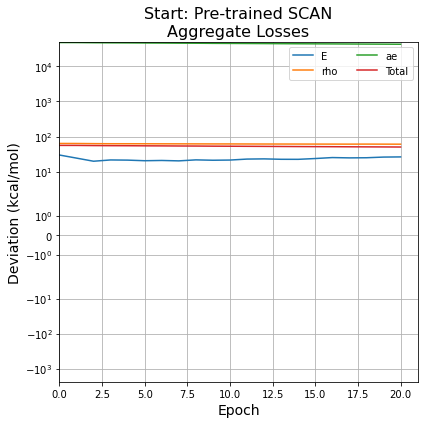

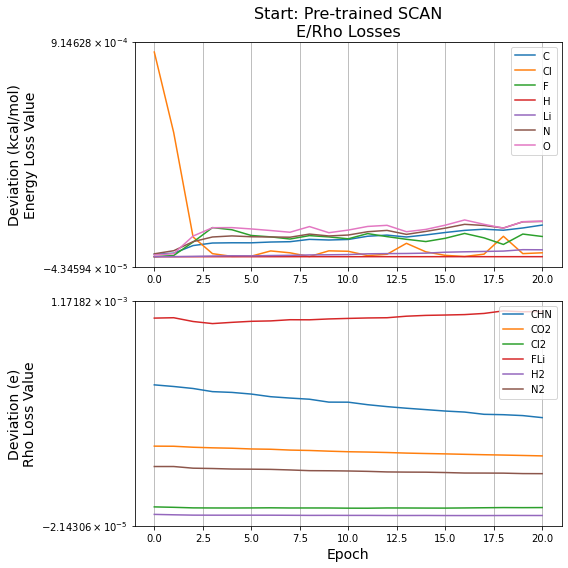

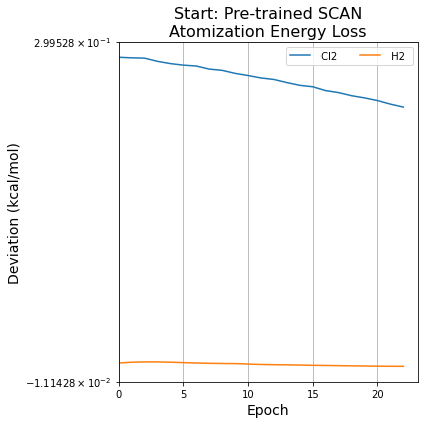

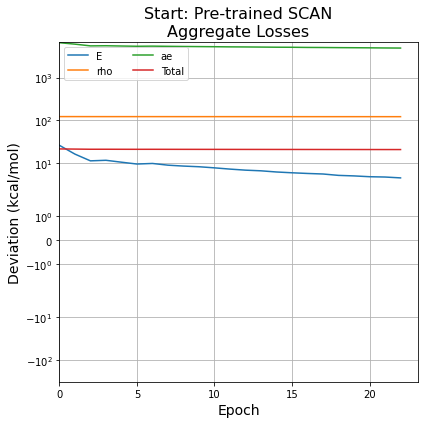

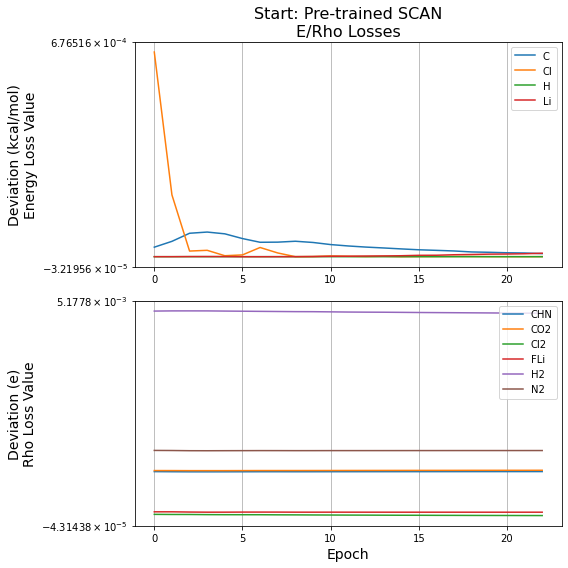

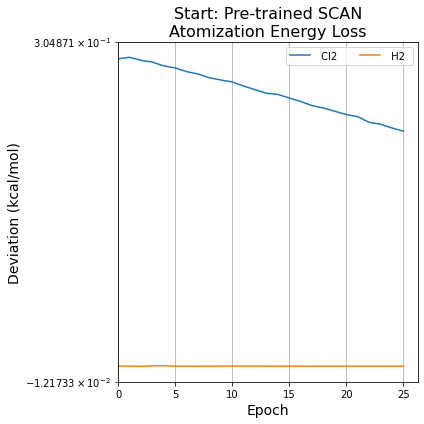

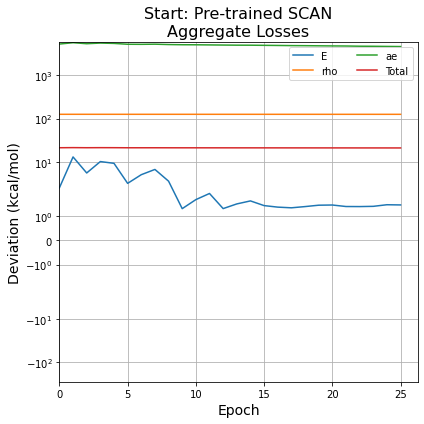

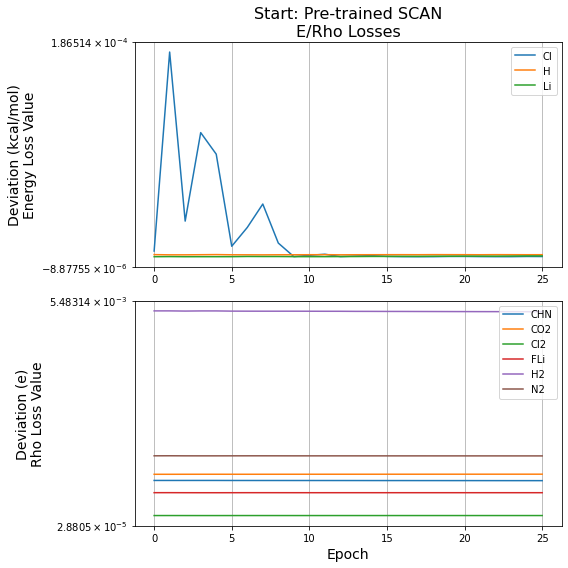

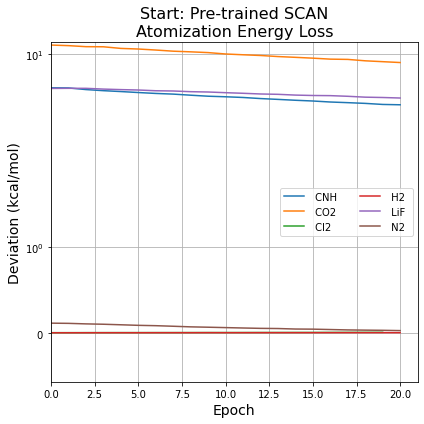

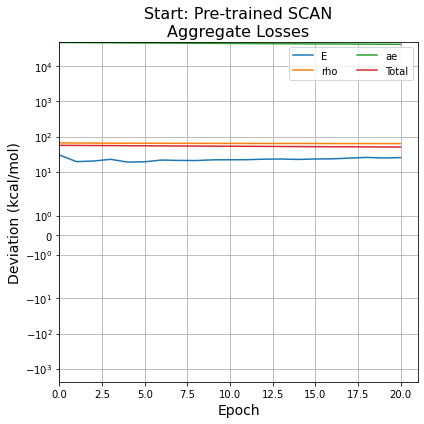

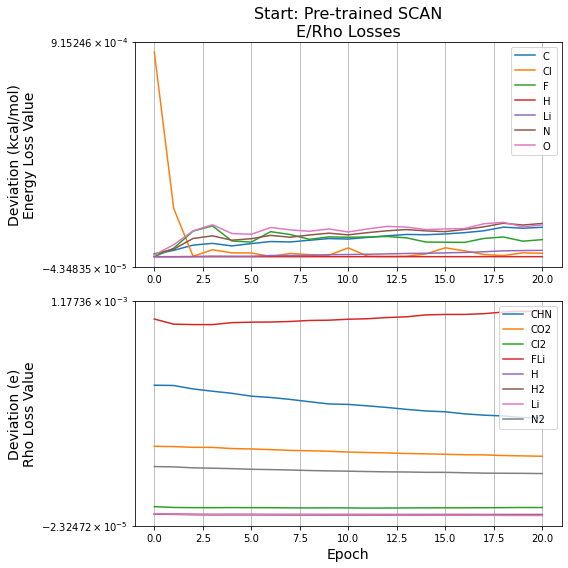

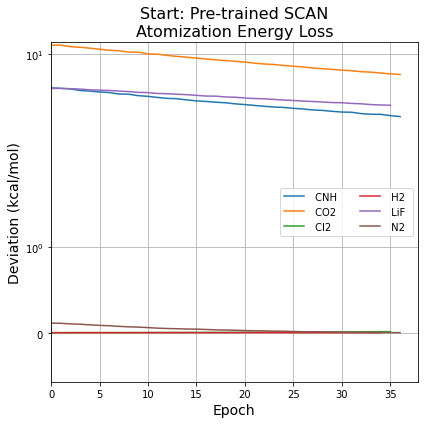

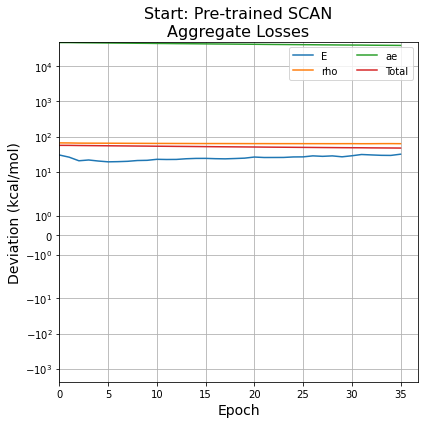

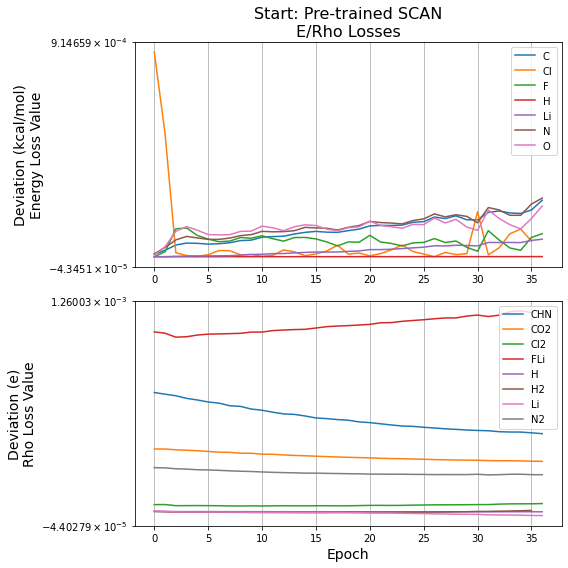

In [5]:
bd = '/home/awills/Documents/Research/swxcd/train/test_subset_ps2'
sd = '/home/awills/Documents/Research/sebshare'
tds = ['01','02','03','04','05','06', '07', '08', '09']
sds = ['02','03','04','05','06','07', '08', '09', '10']
tds += ['07', '08', '09']
sds += ['08', '09', '10']
tds += ['10', '11']
sds += ['11', '12']
#tds = ['06']
#sds = ['07']
for idx, d in enumerate(tds):
    tp = os.path.join(bd, d)
    svd = os.path.join(sd, sds[idx])
    percent = False
    log = True
    pct = ''
    log = '_log' if log else ''
    
    yl = '% Change' if percent else 'Deviation (kcal/mol)'
    yll = [yl, 14]
    
    yl1 = '% Change\nEnergy Loss Value' if percent else 'Deviation (kcal/mol)\nEnergy Loss Value'
    yl2 = '% Change\nRho Loss Value' if percent else 'Deviation (e)\nRho Loss Value'
    yl1l = [yl1, 14]
    yl2l = [yl2, 14]
    
    aesave = os.path.join(svd, 'trainloss_ae{}{}_no0'.format(pct,log))
    tesave = os.path.join(svd, 'trainloss_te{}{}_no0'.format(pct,log))
    eesave = os.path.join(svd, 'trainloss_ee{}{}_no0'.format(pct,log))
    
    plot_train_outputs(direc=tp, percent=percent, log=log,
                      aesave=aesave, tesave=tesave, eesave=eesave,
                      ylabfont = yll, ylabfont1 = yl1l, ylabfont2 = yl2l, escale=H_to_kcalmol)

In [6]:
sds[idx]

TypeError: list indices must be integers or slices, not str

 F 
 H 
 H2 
 Li 
 LiF 
 N 
 N2 


[(<Figure size 432x432 with 1 Axes>,
  <AxesSubplot:title={'center':'Start: Pre-trained SCAN\nChange in Atomization Energy Loss\n y = (y-y[0])'}, xlabel='Epoch', ylabel='% Change'>),
 (<Figure size 432x432 with 1 Axes>,
  <AxesSubplot:title={'center':'Start: Pre-trained SCAN\nChange in Atomization Energy Loss\n y = (y-y[0])'}, xlabel='Epoch', ylabel='% Change'>),
 (<Figure size 576x576 with 2 Axes>,
  <AxesSubplot:title={'center':'Start: Pre-trained SCAN\nChange in E/Rho Losses\n y = (y-y[0])/y[0]'}, ylabel='% Change\nEnergy Loss Value'>,
  <AxesSubplot:xlabel='Epoch', ylabel='% Change\nRho Loss Value'>)]

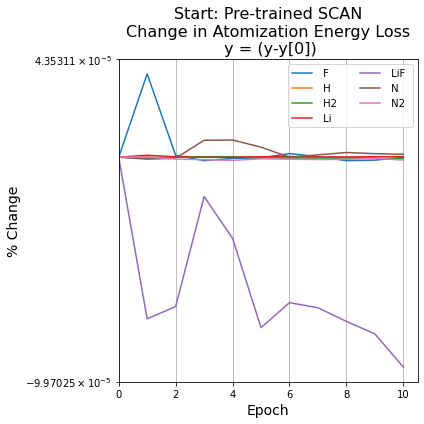

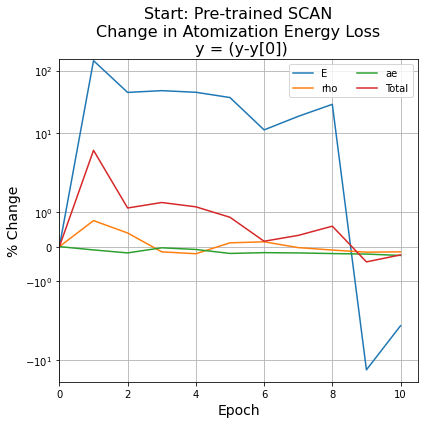

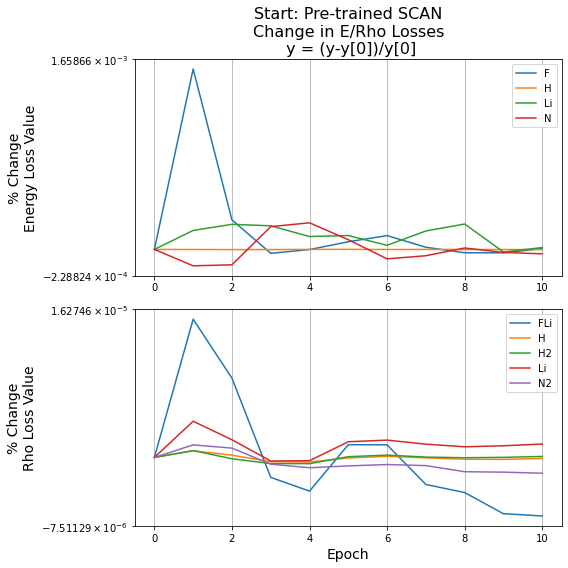

In [29]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts13'
plot_train_outputs(direc=tp, percent=False, log=True)


In [3]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts7'
aep = os.path.join(tp, '2022-08-16_13:24:50.824884_aeloss.dat')
tep = os.path.join(tp, '2022-08-16_13:24:50.824884_totallosses.dat')
eep = os.path.join(tp, '2022-08-16_13:24:50.824884_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, index_col=False, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 Li 
 LiF 
 N 
 N2 


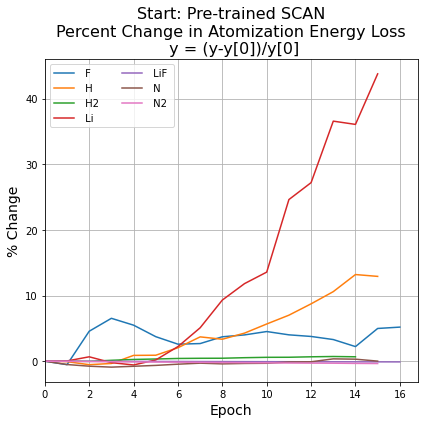

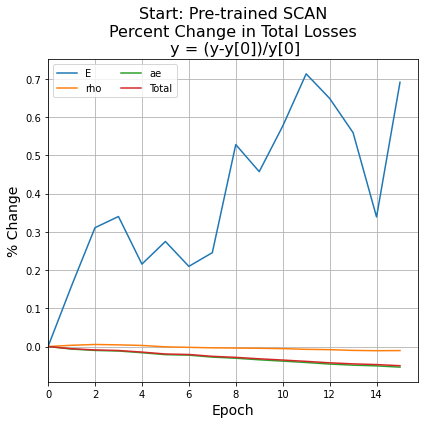

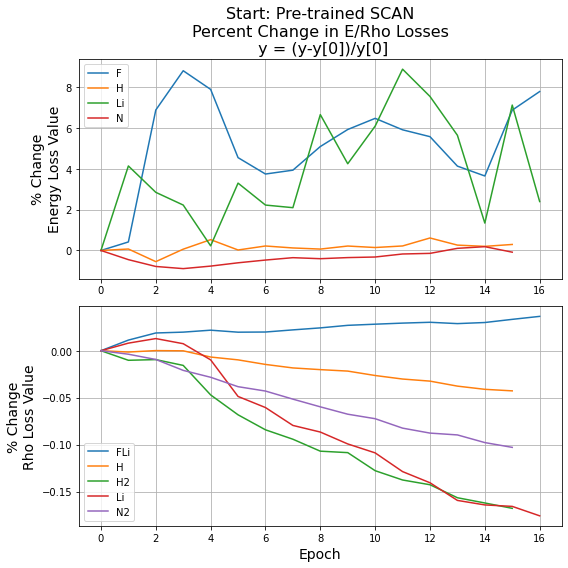

In [4]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    #y = (y - y[0])
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts7ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts7te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts7er.png'), dpi=800)

In [4]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts6'
aep = os.path.join(tp, '2022-08-15_14:55:08.886169_aeloss.dat')
tep = os.path.join(tp, '2022-08-15_14:55:08.886169_totallosses.dat')
eep = os.path.join(tp, '2022-08-15_14:55:08.886169_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, index_col=False, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 Li 
 LiF 
 N 
 N2 


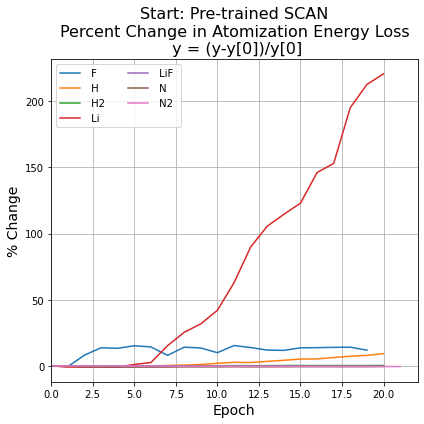

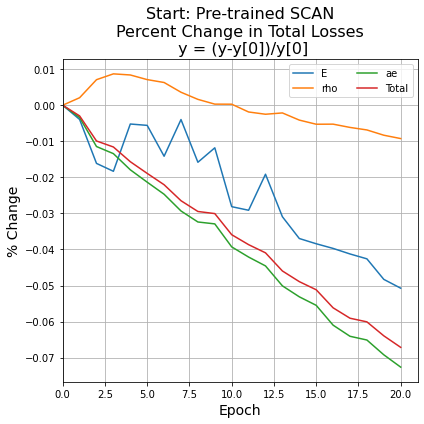

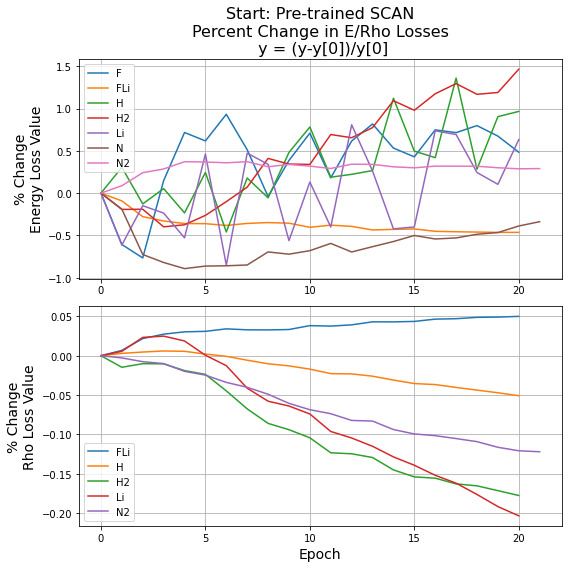

In [8]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    #y = (y - y[0])
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts6ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts6te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts6er.png'), dpi=800)

In [11]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts5'
aep = os.path.join(tp, '2022-08-14_18:00:08.448073_aeloss.dat')
tep = os.path.join(tp, '2022-08-14_18:00:08.448073_totallosses.dat')
eep = os.path.join(tp, '2022-08-14_18:00:08.448073_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, index_col=False, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 Li 
 LiF 
 N 
 N2 


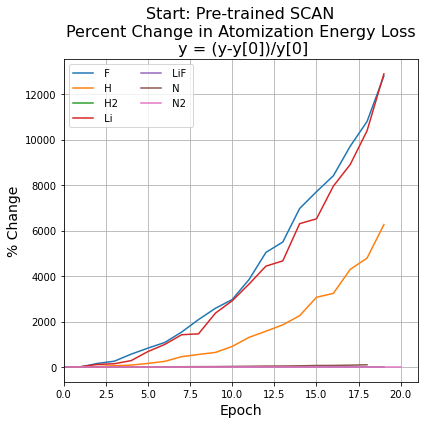

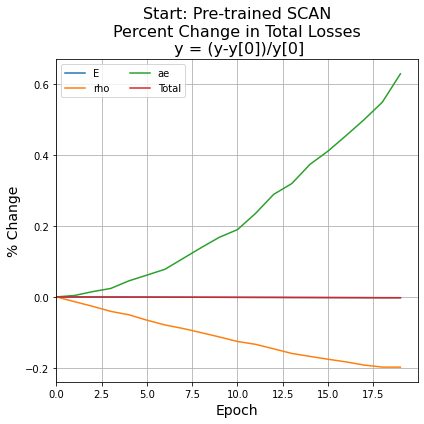

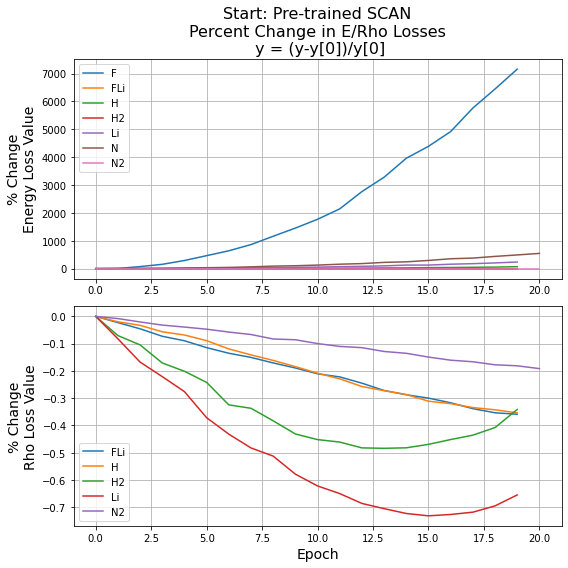

In [12]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts5ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts5te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts5er.png'), dpi=800)

In [8]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts4'
aep = os.path.join(tp, '2022-08-13_16:40:27.943602_aeloss.dat')
tep = os.path.join(tp, '2022-08-13_16:40:27.943602_totallosses.dat')
eep = os.path.join(tp, '2022-08-13_16:40:27.943602_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, index_col=False, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 Li 
 LiF 
 N 
 N2 


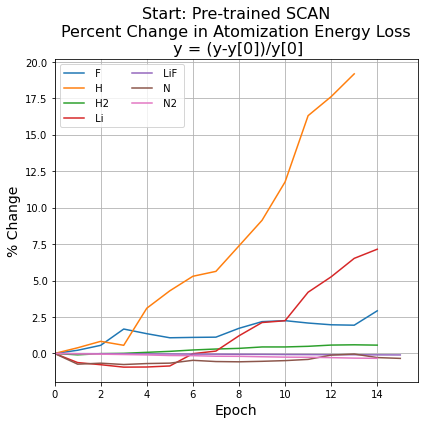

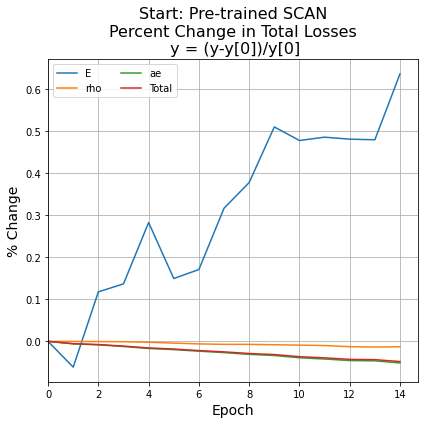

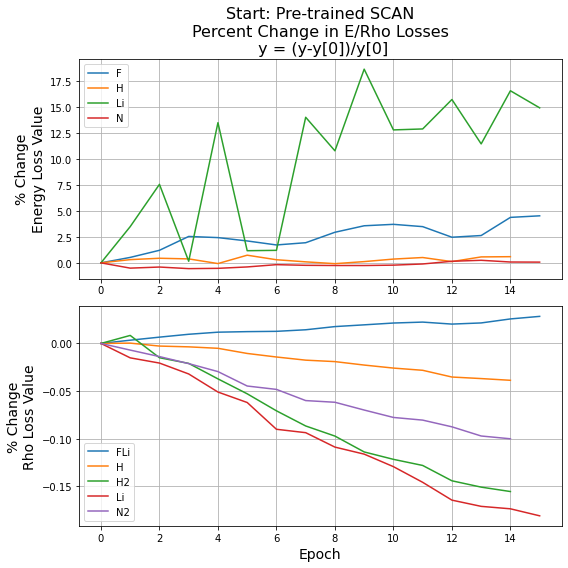

In [10]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts4ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts4te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts4er.png'), dpi=800)

In [3]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts3'
aep = os.path.join(tp, '2022-08-10_16:48:21.436750_aeloss.dat')
tep = os.path.join(tp, '2022-08-10_16:48:21.436750_totallosses.dat')
eep = os.path.join(tp, '2022-08-10_16:48:21.436750_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


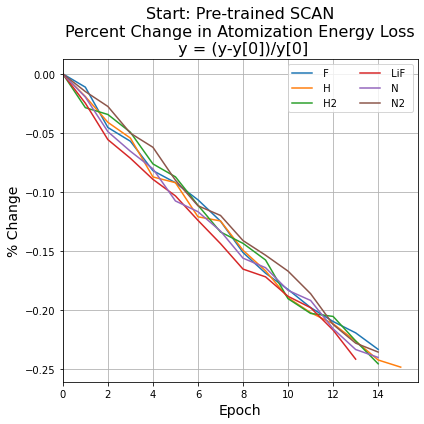

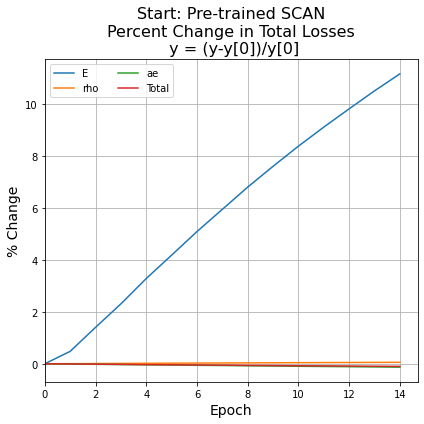

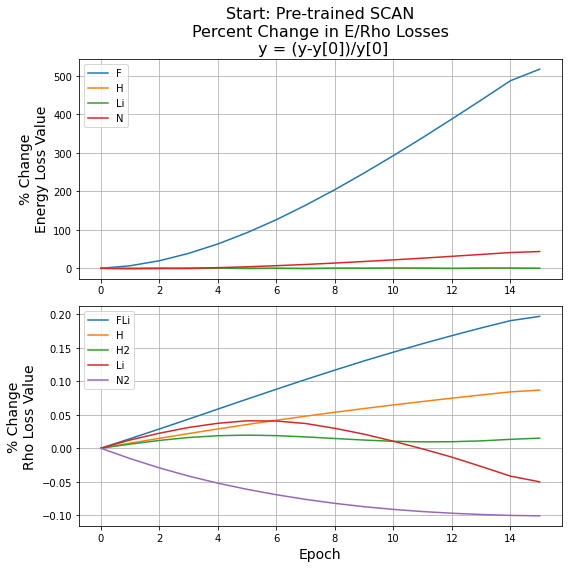

In [4]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts3ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts3te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts3er.png'), dpi=800)

In [10]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts2'
aep = os.path.join(tp, '2022-08-05_17:01:57.494806_aeloss.dat')
tep = os.path.join(tp, '2022-08-05_17:01:57.494806_totallosses.dat')
eep = os.path.join(tp, '2022-08-05_17:01:57.494806_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


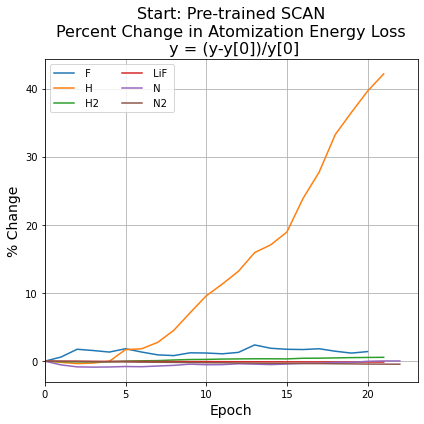

In [11]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2ae.png'), dpi=800)

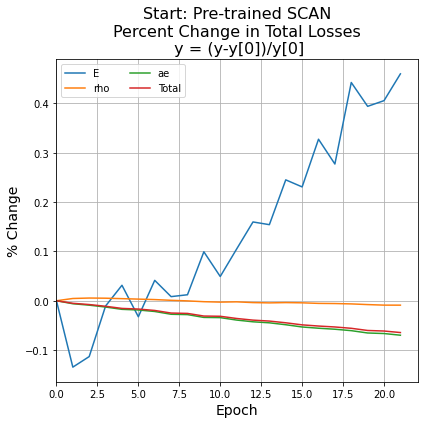

In [4]:
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2te.png'), dpi=800)

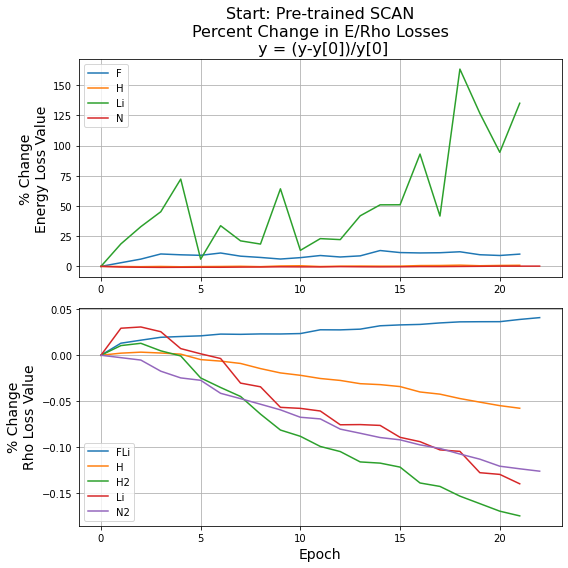

In [5]:
def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2er.png'), dpi=800)

In [6]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/xcd'
aep = os.path.join(tp, '2022-08-06_13:30:34.553955_aeloss.dat')
tep = os.path.join(tp, '2022-08-06_13:30:34.553955_totallosses.dat')
eep = os.path.join(tp, '2022-08-06_13:30:34.553955_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


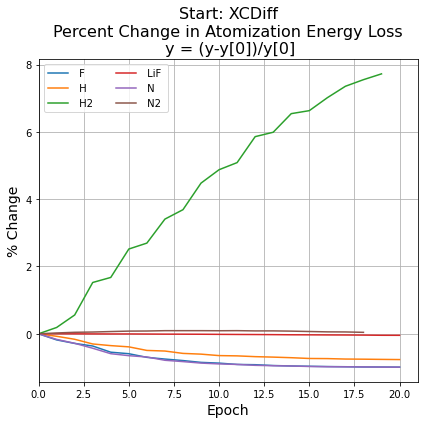

In [7]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: XCDiff\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcdae.png'), dpi=800)

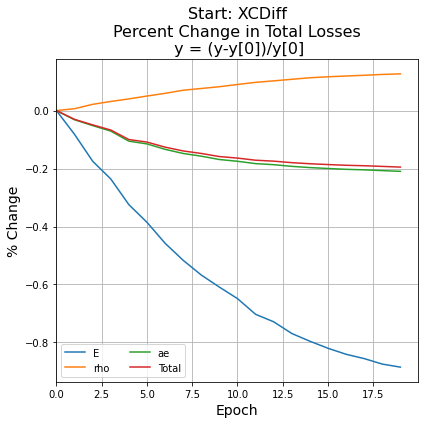

In [8]:
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: XCDiff\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcdte.png'), dpi=800)

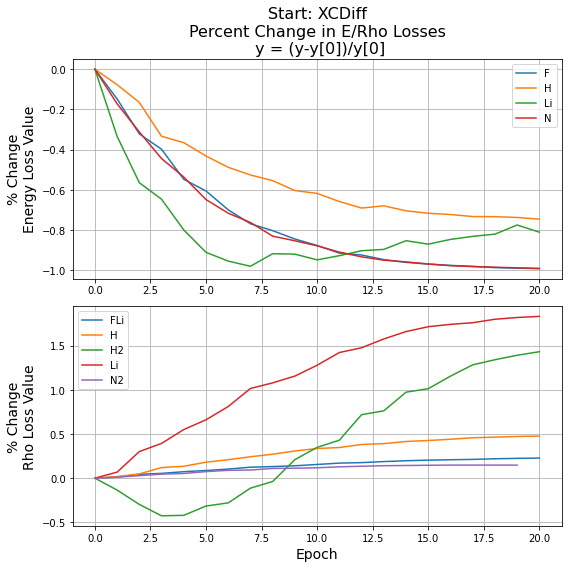

In [9]:
def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: XCDiff\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcder.png'), dpi=800)